In [3]:
import pandas as pd
from sqlalchemy import create_engine
import os 
from dotenv import load_dotenv

In [4]:
# Load environment variables
dotenv_path = os.path.join(os.path.dirname(os.getcwd()), 'config', '.env')
load_dotenv(dotenv_path=dotenv_path)

engine = create_engine(f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}")


In [5]:
data = pd.read_sql("SELECT * FROM salesperson_summary", engine)

data.head()

,year,salesperson,num_completed_orders,total_sales,total_profit,avg_order_value,avg_profit_per_order,total_discounted_revenue,total_discount_given,total_revenue_lost,units_lost,customers_lost
0,2019.0,Adam Smith,6,7700.412061,6476.046902,1283.40,1079.34,7700.412061,1301.277939,29048.322476,155.0,34
1,2019.0,Bradley Howe,10,13102.462313,10997.349108,1310.25,1099.73,13102.462313,1532.077687,38746.933866,176.0,28
2,2019.0,Caitlyn Boyd,9,11747.390995,9900.168229,1305.27,1100.02,11747.390995,1718.809005,30917.483693,169.0,27
3,2019.0,Caleb Camacho,15,18142.850260,15022.664692,1209.52,1001.51,18142.850260,4422.059740,35366.931996,150.0,28
4,2019.0,Charles Smith,14,20252.237109,17156.825827,1446.59,1225.49,20252.237109,2787.262891,34175.799867,160.0,28


In [6]:
#Feature Engineering

df = data.copy()

# Derived metrics
df["discount_rate"] = df["total_discount_given"] / df["total_sales"]
df["loss_rate"] = df["total_revenue_lost"] / df["total_sales"]
df["profit_margin"] = df["total_profit"] / df["total_sales"]

In [7]:
#Standardize for clustering
from sklearn.preprocessing import StandardScaler

# Feature selection for clustering
features = [
    "avg_order_value",
    "avg_profit_per_order",
    "discount_rate",
    "profit_margin",
    "num_completed_orders",
    "loss_rate"
]

X = df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [8]:
from sklearn.cluster import KMeans

# Try with 3 to 5 clusters initially
kmeans = KMeans(n_clusters=4, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

cluster_summary = df.groupby("cluster")[features].mean().round(2)
# save cluster to database
cluster_summary.to_sql("salesperson_cluster_summary", engine, if_exists="replace", index=False)
# save to database
cluster_summary.to_csv("salesperson_cluster_summary.csv", index=False)

cluster_summary


,avg_order_value,avg_profit_per_order,discount_rate,profit_margin,num_completed_orders,loss_rate
cluster,,,,,,
0,1694.70,1473.39,0.18,0.87,9.47,2.75
1,1006.15,815.52,0.18,0.81,12.14,2.95
2,849.08,670.53,0.21,0.78,7.33,6.83
3,1313.89,1109.35,0.17,0.84,10.16,3.01


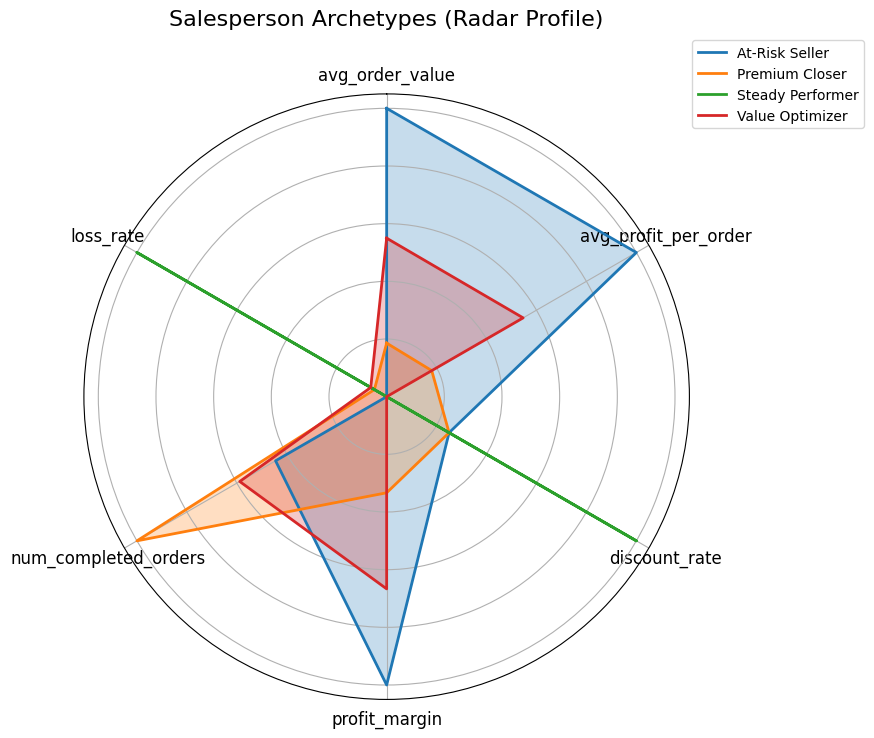

In [7]:
#Visualization
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Normalize for radar plot using Min-Max Scaling
cluster_scaled = cluster_summary.copy()
for col in cluster_scaled.columns:
    min_val = cluster_scaled[col].min()
    max_val = cluster_scaled[col].max()
    cluster_scaled[col] = (cluster_scaled[col] - min_val) / (max_val - min_val)

# Step 2: Radar chart setup
labels = cluster_scaled.columns.tolist()
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the circle

# Step 3: Create plot
fig, ax = plt.subplots(figsize=(9, 9), subplot_kw=dict(polar=True))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Optional: rename clusters meaningfully
cluster_labels = ['At-Risk Seller', 'Premium Closer', 'Steady Performer', 'Value Optimizer']
cluster_scaled.index = cluster_labels

# Step 4: Plot each cluster
for i, (idx, row) in enumerate(cluster_scaled.iterrows()):
    values = row.tolist() + [row.tolist()[0]]  # close the shape
    ax.plot(angles, values, label=idx, color=colors[i], linewidth=2)
    ax.fill(angles, values, alpha=0.25, color=colors[i])

# Step 5: Axis and legend
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=12)
ax.set_title('Salesperson Archetypes (Radar Profile)', size=16, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.set_yticklabels([])  # Hide radial labels for cleaner look

plt.tight_layout()
plt.show()


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target
features = ['discount_rate', 'avg_order_value', 'num_completed_orders', 'loss_rate']
target = 'avg_profit_per_order'

X = df[features]
y = df[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print("R² Score:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

R² Score: 0.9981148164166848
MSE: 164.12557194324938


In [10]:
# Feature importance
importance = pd.Series(model.coef_, index=features).sort_values(ascending=False)
print("\nFeature Influence on avg_profit_per_order:")
print(importance)


Feature Influence on avg_profit_per_order:
avg_order_value         1674.879737
loss_rate                  5.531436
discount_rate             -3.221834
num_completed_orders      -6.015900
dtype: float64


/home/juma/pricing_analysis/pricing-analytics-pipeline/penv/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


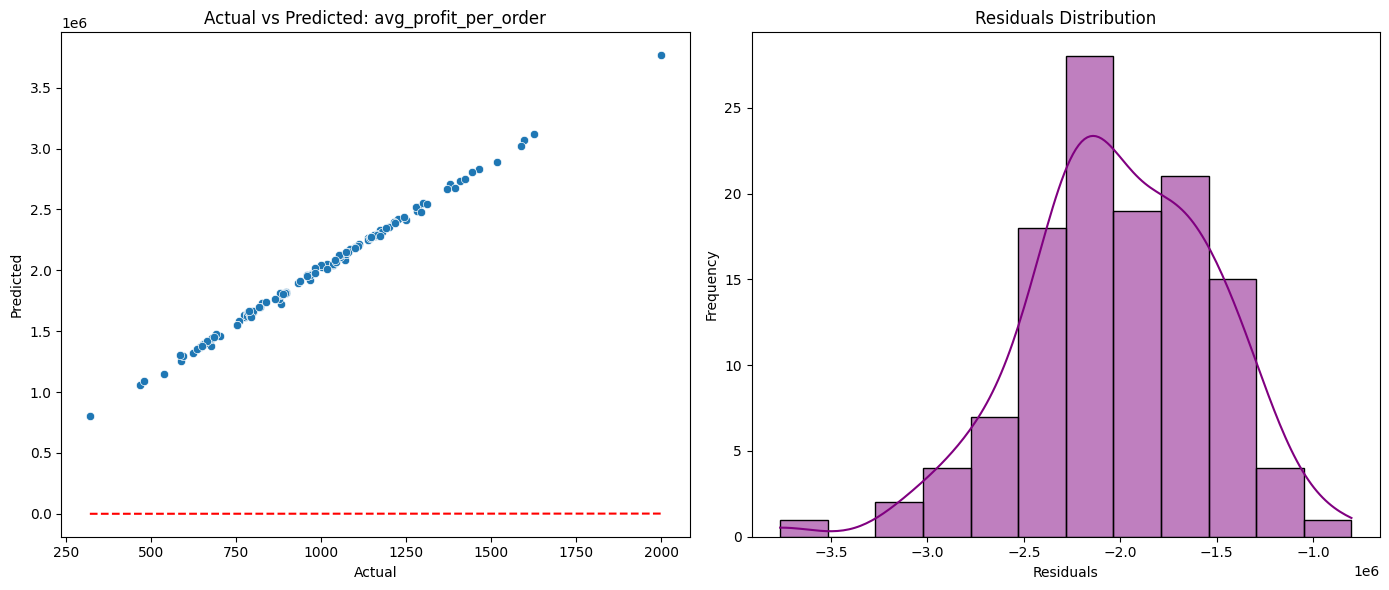

In [11]:
#Visualization of predictions and residuals
import seaborn as sns
from sklearn.metrics import mean_squared_error

# Predictions and residuals
y_pred = model.predict(X)
residuals = y - y_pred

# Set up the figure
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Actual vs Predicted
sns.scatterplot(x=y, y=y_pred, ax=axs[0])
axs[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
axs[0].set_title("Actual vs Predicted: avg_profit_per_order")
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Predicted")

# Plot 2: Residuals
sns.histplot(residuals, kde=True, ax=axs[1], color='purple')
axs[1].set_title("Residuals Distribution")
axs[1].set_xlabel("Residuals")
axs[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


In [9]:
# Year on-year growth Per Salesperson
# Ensure 'year' is treated as int
df['year'] = df['year'].astype(int)

# Sort to prepare for YoY calculation
df_sorted = df.sort_values(['salesperson', 'year'])

# Define metrics to track YoY
metrics = ['total_sales', 'total_profit', 'avg_order_value', 'avg_profit_per_order', 'num_completed_orders']

# Compute YoY % change per salesperson
yoy_df = df_sorted.groupby('salesperson')[metrics].pct_change().round(3) * 100
yoy_df.columns = [f'{col}_yoy' for col in yoy_df.columns]


# Combine back with the original sorted dataframe
df_growth = pd.concat([df_sorted, yoy_df], axis=1)

# Fill NaN values with 0 for the first year of each salesperson
df_growth.fillna(0, inplace=True)
# Reset index for clarity
df_growth.reset_index(drop=True, inplace=True)

# Save to database
df_growth.to_sql('salesperson_growth_yoy', engine, if_exists='replace', index=False)

# Display a sample
df_growth.head(10)

,year,salesperson,num_completed_orders,total_sales,total_profit,avg_order_value,avg_profit_per_order,total_discounted_revenue,total_discount_given,total_revenue_lost,...,customers_lost,discount_rate,loss_rate,profit_margin,cluster,total_sales_yoy,total_profit_yoy,avg_order_value_yoy,avg_profit_per_order_yoy,num_completed_orders_yoy
0,2019,Adam Smith,6,7700.412061,6476.046902,1283.40,1079.34,7700.412061,1301.277939,29048.322476,...,34,0.168988,3.772308,0.841000,3,0.0,0.0,0.0,0.0,0.0
1,2020,Adam Smith,14,15248.316575,12570.717778,1089.17,897.91,15248.316575,2402.283425,29721.954969,...,25,0.157544,1.949196,0.824400,1,98.0,94.1,-15.1,-16.8,133.3
2,2021,Adam Smith,8,12052.411810,10239.301545,1506.55,1279.91,12052.411810,1367.108190,27663.047363,...,27,0.113430,2.295229,0.849565,3,-21.0,-18.5,38.3,42.5,-42.9
3,2022,Adam Smith,13,14740.822705,12117.429405,1133.91,932.11,14740.822705,3159.467295,37808.863847,...,34,0.214335,2.564909,0.822032,1,22.3,18.3,-24.7,-27.2,62.5
4,2023,Adam Smith,10,8060.679740,6345.259500,806.07,634.53,8060.679740,1067.450260,21813.970544,...,17,0.132427,2.706220,0.787187,1,-45.3,-47.6,-28.9,-31.9,-23.1
5,2024,Adam Smith,4,4569.470333,3752.940440,1142.37,938.24,4569.470333,655.129667,32311.802132,...,34,0.143371,7.071236,0.821308,2,-43.3,-40.9,41.7,47.9,-60.0
6,2019,Bradley Howe,10,13102.462313,10997.349108,1310.25,1099.73,13102.462313,1532.077687,38746.933866,...,28,0.116931,2.957225,0.839335,3,0.0,0.0,0.0,0.0,0.0
7,2020,Bradley Howe,9,6963.938849,5351.826448,773.77,594.65,6963.938849,1492.461151,43105.916001,...,32,0.214313,6.189876,0.768506,2,-46.9,-51.3,-40.9,-45.9,-10.0
8,2021,Bradley Howe,10,9748.268382,7721.623720,974.83,772.16,9748.268382,1779.911618,21355.341498,...,22,0.182587,2.190681,0.792102,1,40.0,44.3,26.0,29.9,11.1
9,2022,Bradley Howe,12,12866.525684,10532.363018,1072.21,877.70,12866.525684,3220.204316,53007.644520,...,40,0.250278,4.119810,0.818586,1,32.0,36.4,10.0,13.7,20.0


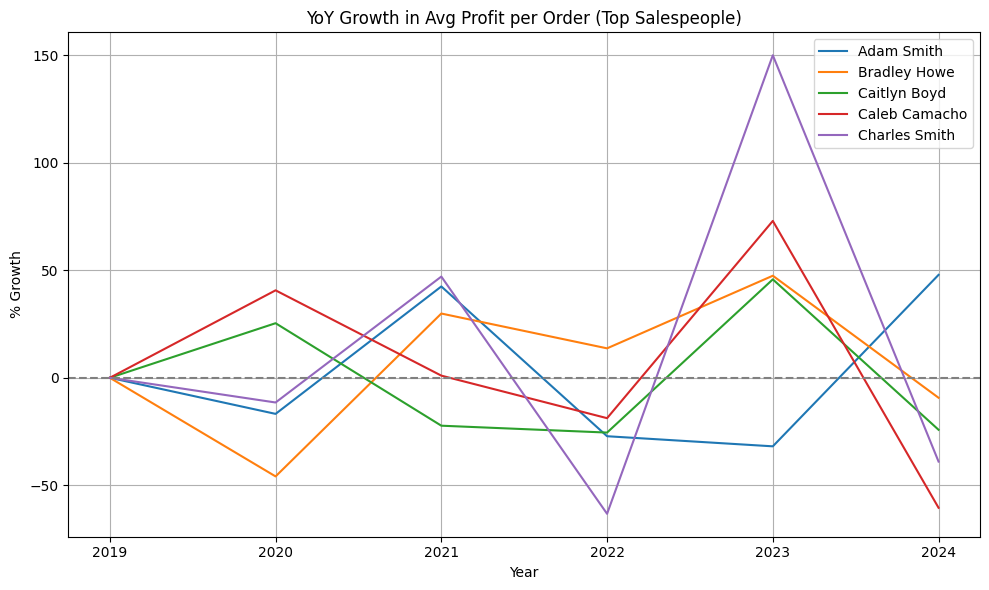

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Let's look at avg_profit_per_order YoY trend for a few top salespeople
top_salespeople = df_growth['salesperson'].value_counts().head(5).index.tolist()

plt.figure(figsize=(10, 6))
for sp in top_salespeople:
    subset = df_growth[df_growth['salesperson'] == sp]
    plt.plot(subset['year'], subset['avg_profit_per_order_yoy'], label=sp)

plt.title('YoY Growth in Avg Profit per Order (Top Salespeople)')
plt.xlabel('Year')
plt.ylabel('% Growth')
plt.axhline(0, color='grey', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Average YoY growth by archetype
yoy_metrics = ['total_sales_yoy', 'total_profit_yoy', 'avg_order_value_yoy', 'avg_profit_per_order_yoy']

archetype_growth = df_growth.groupby('cluster')[yoy_metrics].mean().round(2)


# Add a total growth score column (sum of all YoY metrics)
archetype_growth['growth_score'] = archetype_growth.sum(axis=1)
archetype_growth = archetype_growth.sort_values(by='growth_score', ascending=False)

print("\n Archetypes Ranked by Overall YoY Growth:")
# save to database
archetype_growth.to_sql('archetype_growth', engine, if_exists='replace', index=False)

archetype_growth



 Archetypes Ranked by Overall YoY Growth:


,total_sales_yoy,total_profit_yoy,avg_order_value_yoy,avg_profit_per_order_yoy,growth_score
cluster,,,,,
0,44.20,53.33,47.24,55.50,200.27
3,26.06,31.58,11.86,15.11,84.61
1,11.91,10.41,-11.08,-12.26,-1.02
2,-32.73,-34.70,-20.36,-22.71,-110.50


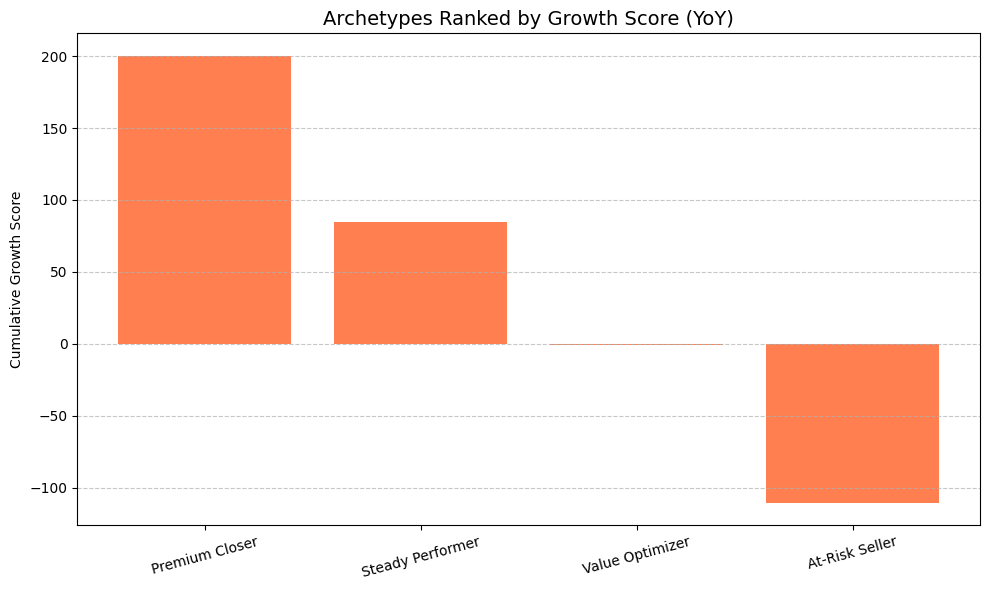

In [24]:
label_map = {
    0: 'Premium Closer',
    3: 'Steady Performer',
    1: 'Value Optimizer',
    2: 'At-Risk Seller'
}
# Add labels
archetype_growth['label'] = archetype_growth.index.map(label_map)

# Sort by score
archetype_growth_sorted = archetype_growth.sort_values('growth_score', ascending=False)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.bar(archetype_growth_sorted['label'], archetype_growth_sorted['growth_score'], color='coral')
plt.title('Archetypes Ranked by Growth Score (YoY)', fontsize=14)
plt.ylabel('Cumulative Growth Score')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

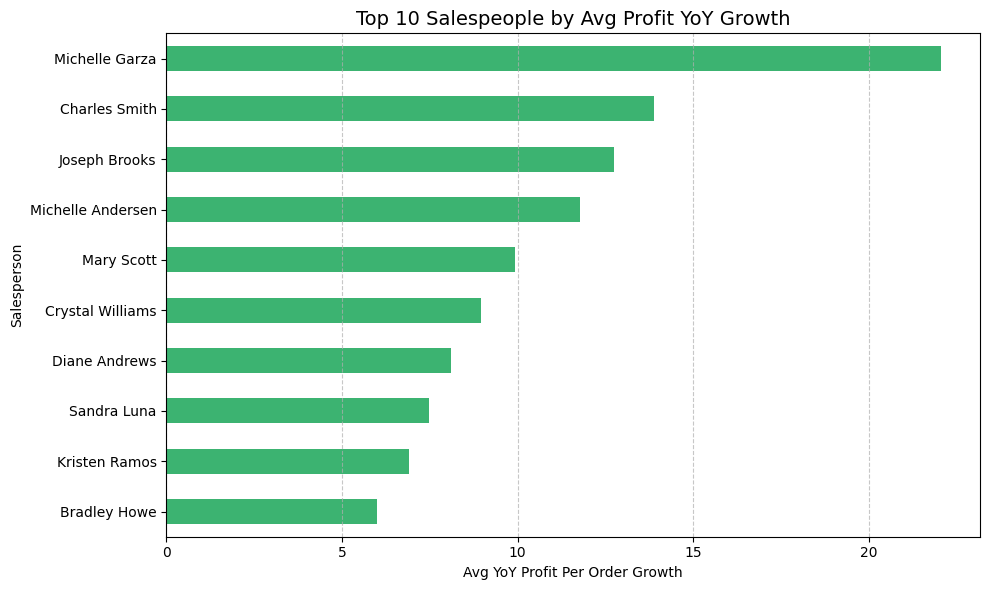

In [25]:
# Top 10 reps by YoY profit growth
top_reps = df_growth.groupby('salesperson')['avg_profit_per_order_yoy'].mean().nlargest(10).sort_values()

plt.figure(figsize=(10,6))
top_reps.plot(kind='barh', color='mediumseagreen')
plt.title('Top 10 Salespeople by Avg Profit YoY Growth', fontsize=14)
plt.xlabel('Avg YoY Profit Per Order Growth')
plt.ylabel('Salesperson')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
